# Compare Best Results from Multiplicative Case

## Product of fluorescence reporters, 2 step experiment

Description of the script: bla bla bla ...

   ............................................................................................................................................................................................................................................

### Import Required libraries

In [1]:
# Common python libraries
import numpy as np
# from scipy.integrate import odeint
# from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
# import scipy
import pandas as pd
# import seaborn as sns
import pickle
# import math

# Gaussian Process Fitting Scripts
import gaussianprocess as gp
# from fitderiv import fitderiv
# import genutils as gu
# import datetime

# Bayesian Optimisation Scripts
from bayes_opt import BayesianOptimization
from bayes_opt.observer import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

# Avoid unnecessary warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Multiprocessing
from multiprocessing import Pool
import multiprocessing as mp

# Functions with Models compyled with Cython
# import Model1_Cython as M1
# import Model2_Cython as M2
# import Model3_Cython as M3

# Function to simulate the 3 models for all parameter draws (needed in separate file for multiprocessesing in windows)
import SolveALLCy as SAC

# Bhattacharyya Distance Function 
import BhattacharyyaDistanceV1 as BD

import seaborn as sns
import matplotlib.ticker
import matplotlib.gridspec as gridspec

## Utility Functions

In [2]:
def utility2 (IPTG1, IPTG2,
             aTc1, aTc2):
    
    # Definition of inputs for the ODEs
        
    inputs = [round(IPTG1,2)+1e-7, int(aTc1)+1e-7, round(IPTG2,2)+1e-7, int(aTc2)+1e-7]
    
    # Initial values for steady state and inputs
    ivss = [1,1e-7,1363.193,28.510]
    pre = [1,1e-7]
    # Event switches and inputs
    sp = [int(i) for i in list(np.linspace(0,(24*60),3))]
    t =  np.linspace(0,(24*60),(24*60)+1)
    
    # load parameter draws for the two models
    pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
    pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))
    
    # Simulation of the system for the two models and extract of results
#     solM1 = SAC.solveALLCy2(t, pM1, sp, inputs, ivss, pre, 'M1')
#     solM2 = SAC.solveALLCy2(t, pM2, sp, inputs, ivss, pre, 'M2')
    if __name__ ==  '__main__': 
        num_processors = mp.cpu_count()
        p=Pool(processes = num_processors)
        for i in range(0,2):
            if i==0:
                r1 = p.apply_async(SAC.solveALLCy2, args=(t, pM1, sp, inputs, ivss, pre, 'M1'))
            elif i==1:
                r2 = p.apply_async(SAC.solveALLCy2, args=(t, pM2, sp, inputs, ivss, pre, 'M2'))
        
        p.close()
        p.join() 
    
    solM1 = r1.get()
    solM2 = r2.get()    
    
    RFP_M1 = solM1[:,0:len(pM1[:,1])]
    GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]
    
    RFP_M2 = solM2[:,0:len(pM2[:,1])]
    GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]
    
    # Gaussian Process Regression and Reduction
    
    # Means and standard deviations for each time point for each species and for each model
    tgp = np.linspace(0,(24*60),round(24*60/5)+1)
    
    muR3 = RFP_M2.mean(axis = 1) # Model 2, RFP
    sdR3 = RFP_M2.std(axis = 1)
    muG3 = GFP_M2.mean(axis = 1) # Model 2, GFP
    sdG3 = GFP_M2.std(axis = 1)
    muR2 = RFP_M1.mean(axis = 1) # Model 1, RFP
    sdR2 = RFP_M1.std(axis = 1)
    muG2 = GFP_M1.mean(axis = 1) # Model 1, GFP
    sdG2 = GFP_M1.std(axis = 1)

    # Gaussian Process regression
    gR3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR3, (sdR3**2)) # RFP, Model 2
    gR3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR3.predict(tgp)
    
    gG3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG3, (sdG3**2)) # GFP, Model 2
    gG3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gG3.predict(tgp)
    
    gR2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR2, (sdR2**2)) # RFP, Model 1
    gR2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR2.predict(tgp)
    
    gG2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG2, (sdG2**2)) # GFP, Model 1
    gG2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gG2.predict(tgp)
    
    # Time points reduction

    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R2.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2G3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::10])
    tref = list(tgp[::10])

    
    g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2G2.predict(tref)

    
    # Bhattacharyya distance:
    bdR = BD.BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
    bdG = BD.BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
    
    # Utility function value
    u_B = (bdR*bdG)

    return(u_B)
    


In [3]:
def utility8 (IPTG1, IPTG2, IPTG3, IPTG4, IPTG5, IPTG6, IPTG7, IPTG8,
             aTc1, aTc2, aTc3, aTc4, aTc5, aTc6, aTc7, aTc8):
    
    # Definition of inputs for the ODEs
        
    inputs = [round(IPTG1,2)+1e-7, int(aTc1)+1e-7, round(IPTG2,2)+1e-7, int(aTc2)+1e-7,
              round(IPTG3,2)+1e-7, int(aTc3)+1e-7, round(IPTG4,2)+1e-7, int(aTc4)+1e-7,
              round(IPTG5,2)+1e-7, int(aTc5)+1e-7, round(IPTG6,2)+1e-7, int(aTc6)+1e-7,
              round(IPTG7,2)+1e-7, int(aTc7)+1e-7, round(IPTG8,2)+1e-7, int(aTc8)+1e-7]
    
    # Initial values for steady state and inputs
    ivss = [1,1e-7,1363.193,28.510]
    pre = [1,1e-7]
    # Event switches and inputs
    sp = [int(i) for i in list(np.linspace(0,(24*60),9))]
    t =  np.linspace(0,(24*60),(24*60)+1)
    
    # load parameter draws for the two models
    pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
    pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))
    
    # Simulation of the system for the two models and extract of results
#     solM1 = SAC.solveALLCy2(t, pM1, sp, inputs, ivss, pre, 'M1')
#     solM2 = SAC.solveALLCy2(t, pM2, sp, inputs, ivss, pre, 'M2')
    if __name__ ==  '__main__': 
        num_processors = mp.cpu_count()
        p=Pool(processes = num_processors)
        for i in range(0,2):
            if i==0:
                r1 = p.apply_async(SAC.solveALLCy2, args=(t, pM1, sp, inputs, ivss, pre, 'M1'))
            elif i==1:
                r2 = p.apply_async(SAC.solveALLCy2, args=(t, pM2, sp, inputs, ivss, pre, 'M2'))
        
        p.close()
        p.join() 
    
    solM1 = r1.get()
    solM2 = r2.get()    
    
    RFP_M1 = solM1[:,0:len(pM1[:,1])]
    GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]
    
    RFP_M2 = solM2[:,0:len(pM2[:,1])]
    GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]
    
    # Gaussian Process Regression and Reduction
    
    # Means and standard deviations for each time point for each species and for each model
    tgp = np.linspace(0,(24*60),round(24*60/5)+1)
    
    muR3 = RFP_M2.mean(axis = 1) # Model 2, RFP
    sdR3 = RFP_M2.std(axis = 1)
    muG3 = GFP_M2.mean(axis = 1) # Model 2, GFP
    sdG3 = GFP_M2.std(axis = 1)
    muR2 = RFP_M1.mean(axis = 1) # Model 1, RFP
    sdR2 = RFP_M1.std(axis = 1)
    muG2 = GFP_M1.mean(axis = 1) # Model 1, GFP
    sdG2 = GFP_M1.std(axis = 1)

    # Gaussian Process regression
    gR3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR3, (sdR3**2)) # RFP, Model 2
    gR3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR3.predict(tgp)
    
    gG3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG3, (sdG3**2)) # GFP, Model 2
    gG3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gG3.predict(tgp)
    
    gR2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR2, (sdR2**2)) # RFP, Model 1
    gR2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR2.predict(tgp)
    
    gG2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG2, (sdG2**2)) # GFP, Model 1
    gG2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gG2.predict(tgp)
    
    # Time points reduction

    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R2.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2G3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::10])
    tref = list(tgp[::10])

    
    g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2G2.predict(tref)

    
    # Bhattacharyya distance:
    bdR = BD.BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
    bdG = BD.BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
    
    # Utility function value
    u_B = (bdR*bdG)

    return(u_B)
    


## Load Best Optimisation Results

In [15]:
# optimizerAv1 = pickle.load( open( "F:/UNI/C_Drive/eigg.sms.ed.ac.uk/BayesianOptimisation/CompareAMIGOvsBAYES/config2sAverage1.optim", "rb" ) )
# optimizerAv2 = pickle.load( open( "F:/UNI/C_Drive/eigg.sms.ed.ac.uk/BayesianOptimisation/CompareAMIGOvsBAYES/config2sAverage2.optim", "rb" ) )

# optimizerG1 = pickle.load( open( "F:/UNI/C_Drive/eigg.sms.ed.ac.uk/BayesianOptimisation/CompareAMIGOvsBAYES/config2sGFP1.optim", "rb" ) )
# optimizerG2 = pickle.load( open( "F:/UNI/C_Drive/eigg.sms.ed.ac.uk/BayesianOptimisation/CompareAMIGOvsBAYES/config2sGFP2.optim", "rb" ) )
# optimizerG3 = pickle.load( open( "F:/UNI/C_Drive/eigg.sms.ed.ac.uk/BayesianOptimisation/CompareAMIGOvsBAYES/config2sGFP3.optim", "rb" ) )

# optimizerR1 = pickle.load( open( "F:/UNI/C_Drive/eigg.sms.ed.ac.uk/BayesianOptimisation/CompareAMIGOvsBAYES/config2sRFP1.optim", "rb" ) )
# optimizerR2 = pickle.load( open( "F:/UNI/C_Drive/eigg.sms.ed.ac.uk/BayesianOptimisation/CompareAMIGOvsBAYES/config2sRFP2.optim", "rb" ) )

optimizerM1 = pickle.load( open( "E:/UNI/D_Drive/PhD/GitHub/FOSBE_2019_Data/BEDms/OptimisationDataSingle/OptimisationResults/config8sMultiplicative1.optim", "rb" ) )
optimizerM2 = pickle.load( open( "E:/UNI/D_Drive/PhD/GitHub/FOSBE_2019_Data/BEDms/OptimisationDataSingle/OptimisationResults/config8sMultiplicative2.optim", "rb" ) )



In [16]:
# optimizerM1 = pickle.load( open( "E:/UNI/C_Drive/eigg.sms.ed.ac.uk/BayesianOptimisation/CompareAMIGOvsBAYES/config4sMultiplicative1.optim", "rb" ) )
# optimizerM2 = pickle.load( open( "E:/UNI/C_Drive/eigg.sms.ed.ac.uk/BayesianOptimisation/CompareAMIGOvsBAYES/config4sMultiplicative2.optim", "rb" ) )


optimizerM2.max

{'target': 227981628.7608451,
 'params': {'IPTG1': 0.49870462615681443,
  'IPTG2': 0.8333457374682331,
  'IPTG3': 0.7689459788810549,
  'IPTG4': 0.45865569976813647,
  'IPTG5': 0.8241778905844037,
  'IPTG6': 0.5880900279378812,
  'IPTG7': 0.9424940626937531,
  'IPTG8': 0.5662456863248144,
  'aTc1': 44.78952040403404,
  'aTc2': 50.862831770257664,
  'aTc3': 58.3392223103054,
  'aTc4': 55.35403467733042,
  'aTc5': 16.66519266422062,
  'aTc6': 19.2543061381933,
  'aTc7': 10.990765827865312,
  'aTc8': 14.778437387237952}}

In [6]:
bayInput = [round(optimizerM2.max['params']['IPTG1'], 2)+1e-7, int(optimizerM2.max['params']['aTc1'])+1e-7, 
          round(optimizerM2.max['params']['IPTG2'], 2)+1e-7, int(optimizerM2.max['params']['aTc2'])+1e-7]
print(bayInput)

[0.4300001, 20.0000001, 0.4500001, 22.0000001]


In [25]:
freInput = [round(0.000005628582664, 2)+1e-7, int(11.070364241559504)+1e-7, 
          round(0.311558497594233, 2)+1e-7, int(11.070218861288224)+1e-7, 
          round(0.618380421776791, 2)+1e-7, int(17.594308872704232)+1e-7, 
          round(0.621251880220008, 2)+1e-7, int(19.157890838657050)+1e-7, 
          round(0.620948944595136, 2)+1e-7, int(20.014328389638322)+1e-7, 
          round(0.999611355659629, 2)+1e-7, int(23.585286323875273)+1e-7,
          round(0.992230612255606, 2)+1e-7, int(24.225935241407200)+1e-7, 
          round(0.996516961032573, 2)+1e-7, int(26.003814848960644)+1e-7]
print(freInput)

[1e-07, 11.0000001, 0.3100001, 11.0000001, 0.6200000999999999, 17.0000001, 0.6200000999999999, 19.0000001, 0.6200000999999999, 20.0000001, 1.0000001, 23.0000001, 0.9900000999999999, 24.0000001, 1.0000001, 26.0000001]


## Compute Utility function values

In [28]:
bayUt = utility2 (bayInput[0], bayInput[2],
                     bayInput[1], bayInput[3])
print('The Utility function Value for the Bayesian result is: '+str(bayUt))

The Utility function Value for the Bayesian result is: 117068398515644.25


In [31]:
freUt = utility8 (freInput[0], freInput[2],
                     freInput[4], freInput[6],
                     freInput[8], freInput[10],
                     freInput[12], freInput[14],
                  
                     freInput[1], freInput[3],
                     freInput[5], freInput[7],
                     freInput[9], freInput[11],
                     freInput[13], freInput[15])
print('The Utility function Value for the Frequentist result is: '+str(freUt))

The Utility function Value for the Frequentist result is: 2057519342.3191578


In [32]:
print('The Utility function Value for the Bayesian result is: '+str(bayUt))
print('The Utility function Value for the Frequentist result is: '+str(freUt))

if bayUt > freUt:
    print('The bayesian result is '+str(bayUt/freUt)+' times better')
elif bayUt < freUt:
    print('The frequentist result is '+str(freUt/bayUt)+' times better')
    
    

The Utility function Value for the Bayesian result is: 117068398515644.25
The Utility function Value for the Frequentist result is: 2057519342.3191578
The bayesian result is 56897.836199045974 times better


## Simulations

### Bayesian Result

In [18]:
ivss = [1,1e-7,1363.193,28.510]
pre = [1,1e-7]
sp = [int(i) for i in list(np.linspace(0,(24*60),3))]
t =  np.linspace(0,(24*60),(24*60)+1)

pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))

# Simulation of the system for the two models and extract of results
if __name__ ==  '__main__': 
    num_processors = mp.cpu_count()
    p=Pool(processes = num_processors)
    for i in range(0,2):
        if i==0:
            r1 = p.apply_async(SAC.solveALLCy2, args=(t, pM1, sp, bayInput, ivss, pre, 'M1'))
        elif i==1:
            r2 = p.apply_async(SAC.solveALLCy2, args=(t, pM2, sp, bayInput, ivss, pre, 'M2'))

    p.close()
    p.join() 

solM1 = r1.get()
solM2 = r2.get()    

RFP_M1 = solM1[:,0:len(pM1[:,1])]
GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]

RFP_M2 = solM2[:,0:len(pM2[:,1])]
GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]

t =  np.linspace(0,(24*60),round(24*60/5)+1)

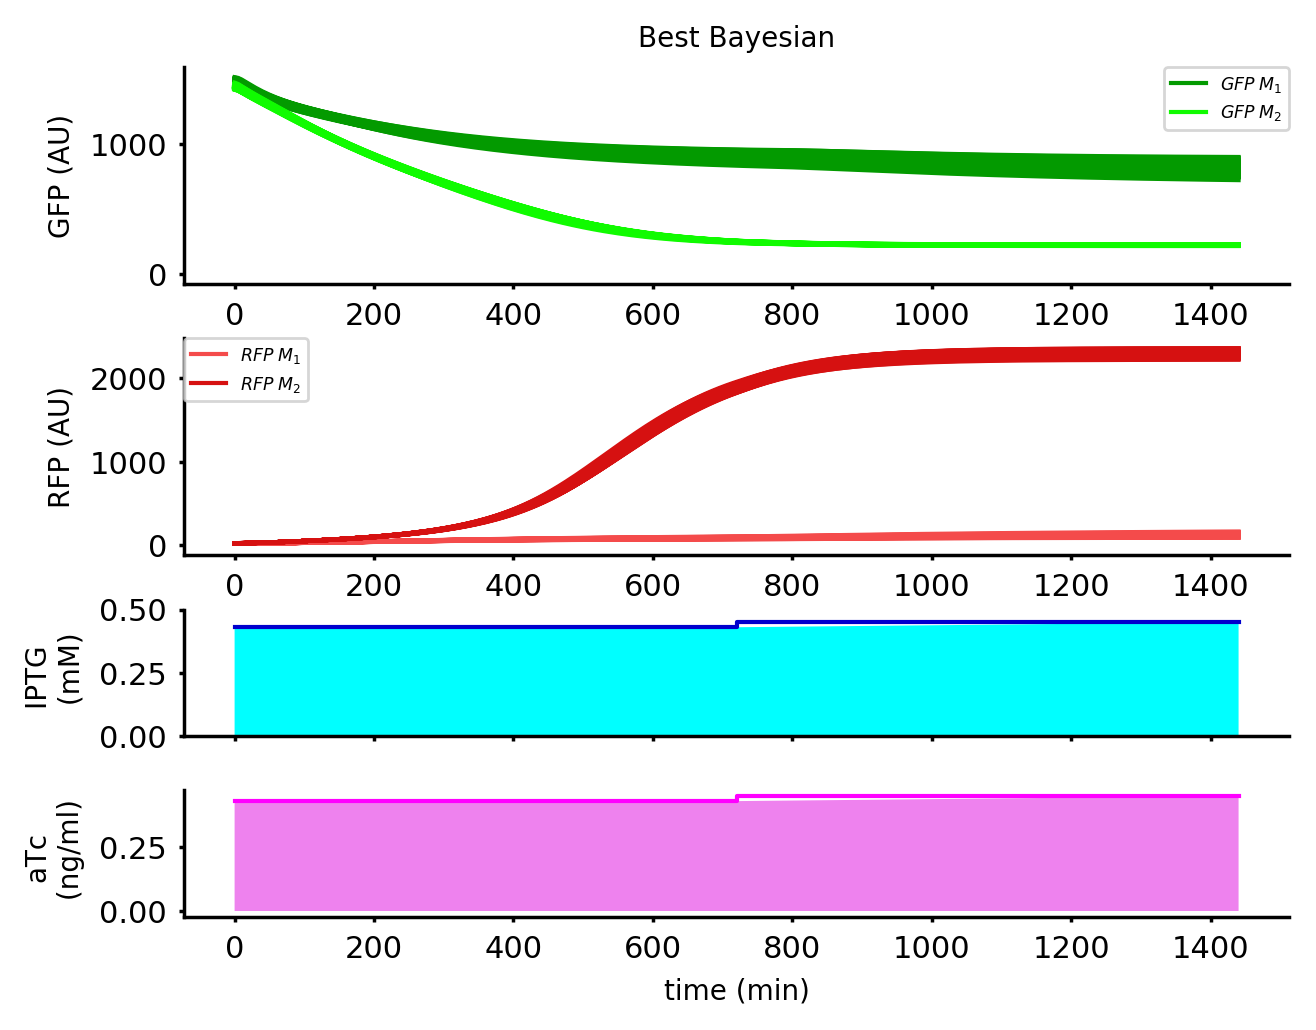

In [117]:

fig = plt.figure(figsize=(5.7, 4.5), dpi = 250)
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8,"axes.tickslabelssize":8,"text.usetex" : True,"text.latex.unicode" : True})  
gs = gridspec.GridSpec(10, 1, hspace = 1.5)

ax1 = plt.subplot(gs[0:3, 0:2])
lines1 = ax1.plot(t, GFP_M1,color='#039a00')
ax1.plot(0,0,color='#039a00', label = '$GFP \; M_{1}$')
lines2 = ax1.plot(t, GFP_M2, color='#10fb00')
ax1.plot(0,0,color='#10fb00', label = '$GFP \; M_{2}$')
ax1.tick_params(length=1.5)
ax1.set_ylabel('GFP (AU)')
ax1.set_xlabel('time (min)')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlabel('')
ax1.set_title('Best Bayesian')


ax2 = plt.subplot(gs[3:6, 0:2])
lines1 = ax2.plot(t, RFP_M1,color='#f44b4b')
ax2.plot(0,0,color='#f44b4b', label = '$RFP \; M_{1}$')
lines2 = ax2.plot(t, RFP_M2, color='#d61111')
ax2.plot(0,0,color='#d61111', label = '$RFP \; M_{2}$')
ax2.tick_params(length=1.5)
ax2.set_ylabel('RFP (AU)')
ax2.set_xlabel('time (min)')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel('')



ax3 = plt.subplot(gs[6:8, 0:2])
ax3.step(sp, [bayInput[0], bayInput[0], bayInput[2]], 'mediumblue')
ax3.fill_between(sp, np.zeros(len(sp)), 
                 [bayInput[0], bayInput[0], bayInput[2]],facecolor='cyan')
ax3.set_xticklabels('')
ax3.set_ylabel('IPTG \n (mM)')
ax3.tick_params(length=1.5)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.set_ylim((0, 0.5))


ax4 = plt.subplot(gs[8:10, 0:2])
ax4.step(sp, [bayInput[0], bayInput[0], bayInput[2]], 'fuchsia')
ax4.fill_between(sp, np.zeros(len(sp)), 
                 [bayInput[0], bayInput[0], bayInput[2]],facecolor='violet')
ax4.set_xlabel('time (min)')
ax4.set_ylabel('aTc \n (ng/ml)')
ax4.tick_params(length=1.5)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

# ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.legend(loc=1, borderaxespad=0., prop={'size': 5})
ax2.legend(loc=2, borderaxespad=0., prop={'size': 5})
plt.show()
fig.savefig('BayesianOptimisationBestMultiplicative.png')

In [149]:
print('The mean GFP value of the last time point for Model 1 is: ', str(np.mean(GFP_M1[288])))
print('The std GFP value of the last time point for Model 1 is: ', str(np.std(GFP_M1[288])),'\n')

print('The mean GFP value of the last time point for Model 2 is: ', str(np.mean(GFP_M2[288])))
print('The std GFP value of the last time point for Model 2 is: ', str(np.std(GFP_M2[288])),'\n')

print('The mean RFP value of the last time point for Model 1 is: ', str(np.mean(RFP_M1[288])))
print('The std RFP value of the last time point for Model 1 is: ', str(np.std(RFP_M1[288])),'\n')

print('The mean RFP value of the last time point for Model 2 is: ', str(np.mean(RFP_M2[288])))
print('The std RFP value of the last time point for Model 2 is: ', str(np.std(RFP_M2[288])))

The mean GFP value of the last time point for Model 1 is:  815.0677097919776
The std GFP value of the last time point for Model 1 is:  25.883249867952234 

The mean GFP value of the last time point for Model 2 is:  223.52058672900682
The std GFP value of the last time point for Model 2 is:  1.964193712408911 

The mean RFP value of the last time point for Model 1 is:  120.99790529771701
The std RFP value of the last time point for Model 1 is:  10.603167569555294 

The mean RFP value of the last time point for Model 2 is:  2285.630270579547
The std RFP value of the last time point for Model 2 is:  22.623003626105415


In [19]:
BGM1 = np.std(GFP_M1,1)
BGM2 = np.std(GFP_M2,1)
BRM1 = np.std(RFP_M1,1)
BRM2 = np.std(RFP_M2,1)

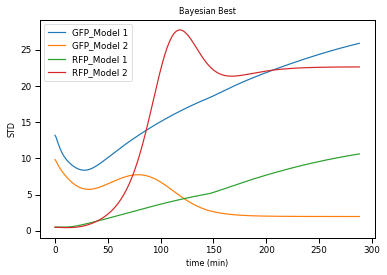

In [160]:
plt.figure()
plt.plot(BGM1, label='GFP_Model 1')
plt.plot(BGM2, label='GFP_Model 2')
plt.plot(BRM1, label='RFP_Model 1')
plt.plot(BRM2, label='RFP_Model 2')
plt.legend()
plt.title('Bayesian Best')
plt.ylabel('STD')
plt.xlabel('time (min)')
plt.show()

### Frequentist Result

In [161]:
ivss = [1,1e-7,1363.193,28.510]
pre = [1,1e-7]
sp = [int(i) for i in list(np.linspace(0,(24*60),9))]
t =  np.linspace(0,(24*60),(24*60)+1)

pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))

# Simulation of the system for the two models and extract of results
if __name__ ==  '__main__': 
    num_processors = mp.cpu_count()
    p=Pool(processes = num_processors)
    for i in range(0,2):
        if i==0:
            r1 = p.apply_async(SAC.solveALLCy2, args=(t, pM1, sp, freInput, ivss, pre, 'M1'))
        elif i==1:
            r2 = p.apply_async(SAC.solveALLCy2, args=(t, pM2, sp, freInput, ivss, pre, 'M2'))

    p.close()
    p.join() 

solM1 = r1.get()
solM2 = r2.get()    

RFP_M1b = solM1[:,0:len(pM1[:,1])]
GFP_M1b = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]

RFP_M2b = solM2[:,0:len(pM2[:,1])]
GFP_M2b = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]

t =  np.linspace(0,(24*60),round(24*60/5)+1)

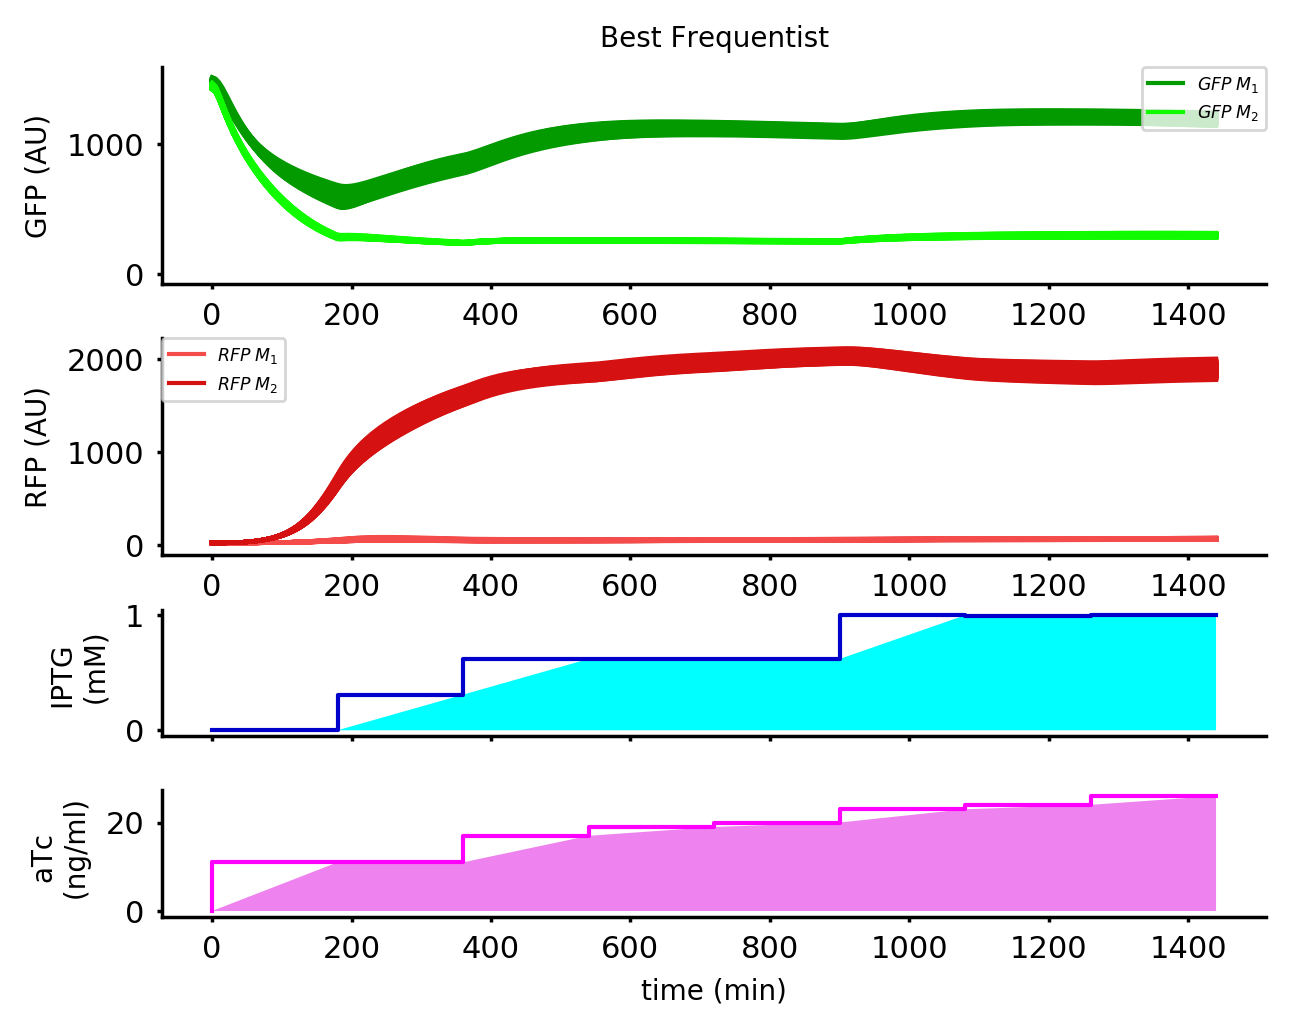

In [124]:

fig = plt.figure(figsize=(5.7, 4.5), dpi = 250)
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8,"axes.tickslabelssize":8,"text.usetex" : True,"text.latex.unicode" : True})  
gs = gridspec.GridSpec(10, 1, hspace = 1.5)

ax1 = plt.subplot(gs[0:3, 0:2])
lines1 = ax1.plot(t, GFP_M1b,color='#039a00')
ax1.plot(0,0,color='#039a00', label = '$GFP \; M_{1}$')
lines2 = ax1.plot(t, GFP_M2b, color='#10fb00')
ax1.plot(0,0,color='#10fb00', label = '$GFP \; M_{2}$')
ax1.tick_params(length=1.5)
ax1.set_ylabel('GFP (AU)')
ax1.set_xlabel('time (min)')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlabel('')
ax1.set_title('Best Frequentist')


ax2 = plt.subplot(gs[3:6, 0:2])
lines1 = ax2.plot(t, RFP_M1b,color='#f44b4b')
ax2.plot(0,0,color='#f44b4b', label = '$RFP \; M_{1}$')
lines2 = ax2.plot(t, RFP_M2b, color='#d61111')
ax2.plot(0,0,color='#d61111', label = '$RFP \; M_{2}$')
ax2.tick_params(length=1.5)
ax2.set_ylabel('RFP (AU)')
ax2.set_xlabel('time (min)')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel('')



ax3 = plt.subplot(gs[6:8, 0:2])
ax3.step(sp, [freInput[0], freInput[0],freInput[2],freInput[4],freInput[6],freInput[8],freInput[10],freInput[12],freInput[14]], 'mediumblue')
ax3.fill_between(sp, np.zeros(len(sp)), 
                 [freInput[0], freInput[0],freInput[2],freInput[4],freInput[6],freInput[8],freInput[10],freInput[12],freInput[14]],facecolor='cyan')
ax3.set_xticklabels('')
ax3.set_ylabel('IPTG \n (mM)')
ax3.tick_params(length=1.5)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)



ax4 = plt.subplot(gs[8:10, 0:2])
ax4.step(sp, [freInput[0], freInput[1],freInput[3],freInput[5], freInput[7],freInput[9], freInput[11],freInput[13], freInput[15]], 'fuchsia')
ax4.fill_between(sp, np.zeros(len(sp)), 
                 [freInput[0], freInput[1],freInput[3],freInput[5], freInput[7],freInput[9], freInput[11],freInput[13], freInput[15]],facecolor='violet')
ax4.set_xlabel('time (min)')
ax4.set_ylabel('aTc \n (ng/ml)')
ax4.tick_params(length=1.5)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

# ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.legend(loc=1, borderaxespad=0., prop={'size': 5})
ax2.legend(loc=2, borderaxespad=0., prop={'size': 5})
plt.show()
fig.savefig('FrequentistOptimisationBestMultiplicative.png')

In [141]:
print('The mean GFP value of the last time point for Model 1 is: ', str(np.mean(GFP_M1[288])))
print('The std GFP value of the last time point for Model 1 is: ', str(np.std(GFP_M1[288])),'\n')

print('The mean GFP value of the last time point for Model 2 is: ', str(np.mean(GFP_M2[288])))
print('The std GFP value of the last time point for Model 2 is: ', str(np.std(GFP_M2[288])),'\n')

print('The mean RFP value of the last time point for Model 1 is: ', str(np.mean(RFP_M1[288])))
print('The std RFP value of the last time point for Model 1 is: ', str(np.std(RFP_M1[288])),'\n')

print('The mean RFP value of the last time point for Model 2 is: ', str(np.mean(RFP_M2[288])))
print('The std RFP value of the last time point for Model 2 is: ', str(np.std(RFP_M2[288])))

The mean GFP value of the last time point for Model 1 is:  1193.3706375976396
The std GFP value of the last time point for Model 1 is:  16.83883763757117 

The mean GFP value of the last time point for Model 2 is:  298.2486579268531
The std GFP value of the last time point for Model 2 is:  5.908298355469859 

The mean RFP value of the last time point for Model 1 is:  72.37514003581175
The std RFP value of the last time point for Model 1 is:  2.8721021306666876 

The mean RFP value of the last time point for Model 2 is:  1892.16827690002
The std RFP value of the last time point for Model 2 is:  38.331527217307666


In [162]:
FGM1 = np.std(GFP_M1b,1)
FGM2 = np.std(GFP_M2b,1)
FRM1 = np.std(RFP_M1b,1)
FRM2 = np.std(RFP_M2b,1)

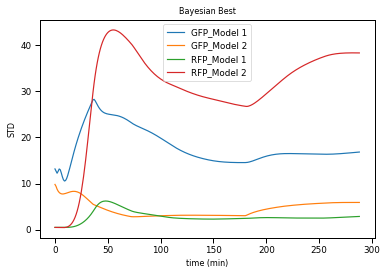

In [163]:
plt.figure()
plt.plot(FGM1, label='GFP_Model 1')
plt.plot(FGM2, label='GFP_Model 2')
plt.plot(FRM1, label='RFP_Model 1')
plt.plot(FRM2, label='RFP_Model 2')
plt.legend()
plt.title('Bayesian Best')
plt.ylabel('STD')
plt.xlabel('time (min)')
plt.show()

In [15]:
import sklearn

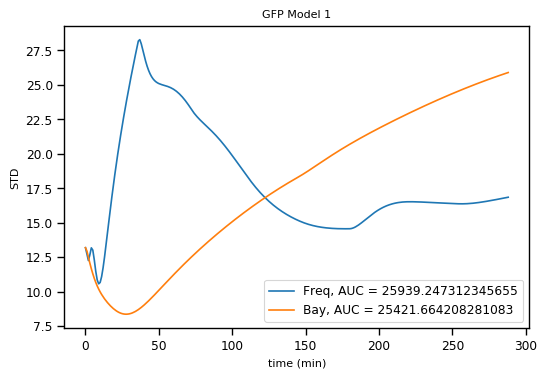

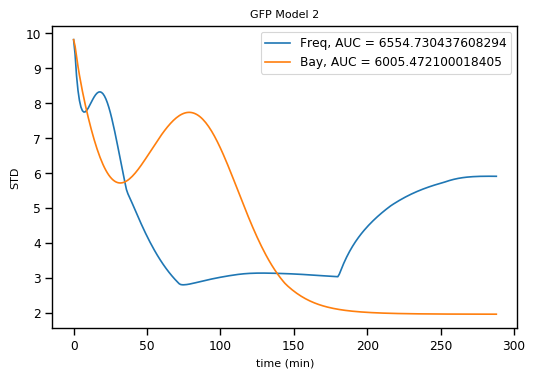

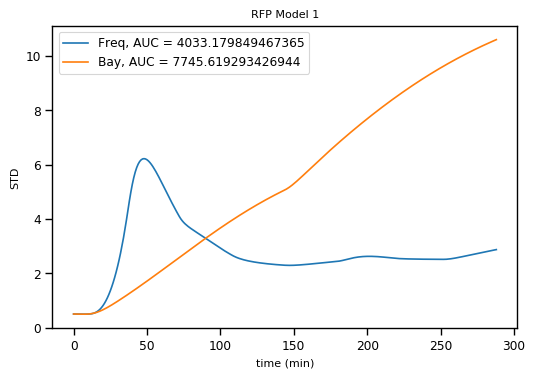

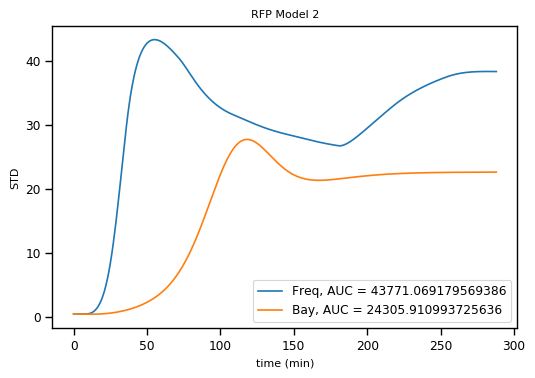

In [177]:

plt.figure(dpi=100)
a1 = sklearn.metrics.auc(t, FGM1)
a2 = sklearn.metrics.auc(t, BGM1)
plt.plot(FGM1, label='Freq, AUC = '+str(a1))
plt.plot(BGM1, label='Bay, AUC = '+str(a2))
plt.legend()
plt.title('GFP Model 1')
plt.ylabel('STD')
plt.xlabel('time (min)')
plt.show()

plt.figure(dpi=100)
a1 = sklearn.metrics.auc(t, FGM2)
a2 = sklearn.metrics.auc(t, BGM2)
plt.plot(FGM2, label='Freq, AUC = '+str(a1))
plt.plot(BGM2, label='Bay, AUC = '+str(a2))
plt.legend()
plt.title('GFP Model 2')
plt.ylabel('STD')
plt.xlabel('time (min)')
plt.show()

plt.figure(dpi=100)
a1 = sklearn.metrics.auc(t, FRM1)
a2 = sklearn.metrics.auc(t, BRM1)
plt.plot(FRM1, label='Freq, AUC = '+str(a1))
plt.plot(BRM1, label='Bay, AUC = '+str(a2))
plt.legend()
plt.title('RFP Model 1')
plt.ylabel('STD')
plt.xlabel('time (min)')
plt.show()

plt.figure(dpi=100)
a1 = sklearn.metrics.auc(t, FRM2)
a2 = sklearn.metrics.auc(t, BRM2)
plt.plot(FRM2, label='Freq, AUC = '+str(a1))
plt.plot(BRM2, label='Bay, AUC = '+str(a2))
plt.legend()
plt.title('RFP Model 2')
plt.ylabel('STD')
plt.xlabel('time (min)')
plt.show()

In [173]:
a1 = sklearn.metrics.auc(t, FGM1)
a2 = sklearn.metrics.auc(t, BGM1)

a3 = sklearn.metrics.auc(t, FGM2)
a4 = sklearn.metrics.auc(t, BGM2)

a5 = sklearn.metrics.auc(t, FRM1)
a6 = sklearn.metrics.auc(t, BRM1)

a7 = sklearn.metrics.auc(t, FRM2)
a8 = sklearn.metrics.auc(t, BRM2)

print('Total AUC for Bayesian case: '+str(a2+a4+a6+a8))
print('Total AUC for Frequentist case: '+str(a1+a3+a5+a7))


Total AUC for Bayesian case: 63478.666595452065
Total AUC for Frequentist case: 80298.2267789907


### Frequentist Result 2 Steps

In [7]:
freInput2 = [round(0.1518, 2)+1e-7, int(12.3599)+1e-7, 
          round(0.8129, 2)+1e-7, int(19.5542)+1e-7]
print(freInput2)

[0.1500001, 12.0000001, 0.8100001, 19.0000001]


In [8]:
bayUt = utility2 (bayInput[0], bayInput[2],
                     bayInput[1], bayInput[3])
print('The Utility function Value for the Bayesian result is: '+str(bayUt))

The Utility function Value for the Bayesian result is: 113732742411100.05


In [9]:
freUt = utility2 (freInput2[0], freInput2[2],
                     freInput2[1], freInput2[3])
print('The Utility function Value for the Frequentist result is: '+str(freUt))

The Utility function Value for the Frequentist result is: 21683907857.57729


In [10]:
print('The Utility function Value for the Bayesian result is: '+str(bayUt))
print('The Utility function Value for the Frequentist result is: '+str(freUt))

if bayUt > freUt:
    print('The bayesian result is '+str(bayUt/freUt)+' times better')
elif bayUt < freUt:
    print('The frequentist result is '+str(freUt/bayUt)+' times better')
    
    

The Utility function Value for the Bayesian result is: 113732742411100.05
The Utility function Value for the Frequentist result is: 21683907857.57729
The bayesian result is 5245.029777755532 times better


In [12]:
ivss = [1,1e-7,1363.193,28.510]
pre = [1,1e-7]
sp = [int(i) for i in list(np.linspace(0,(24*60),3))]
t =  np.linspace(0,(24*60),(24*60)+1)

pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))

# Simulation of the system for the two models and extract of results
if __name__ ==  '__main__': 
    num_processors = mp.cpu_count()
    p=Pool(processes = num_processors)
    for i in range(0,2):
        if i==0:
            r1 = p.apply_async(SAC.solveALLCy2, args=(t, pM1, sp, freInput2, ivss, pre, 'M1'))
        elif i==1:
            r2 = p.apply_async(SAC.solveALLCy2, args=(t, pM2, sp, freInput2, ivss, pre, 'M2'))

    p.close()
    p.join() 

solM1 = r1.get()
solM2 = r2.get()    

RFP_M1b = solM1[:,0:len(pM1[:,1])]
GFP_M1b = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]

RFP_M2b = solM2[:,0:len(pM2[:,1])]
GFP_M2b = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]

t =  np.linspace(0,(24*60),round(24*60/5)+1)

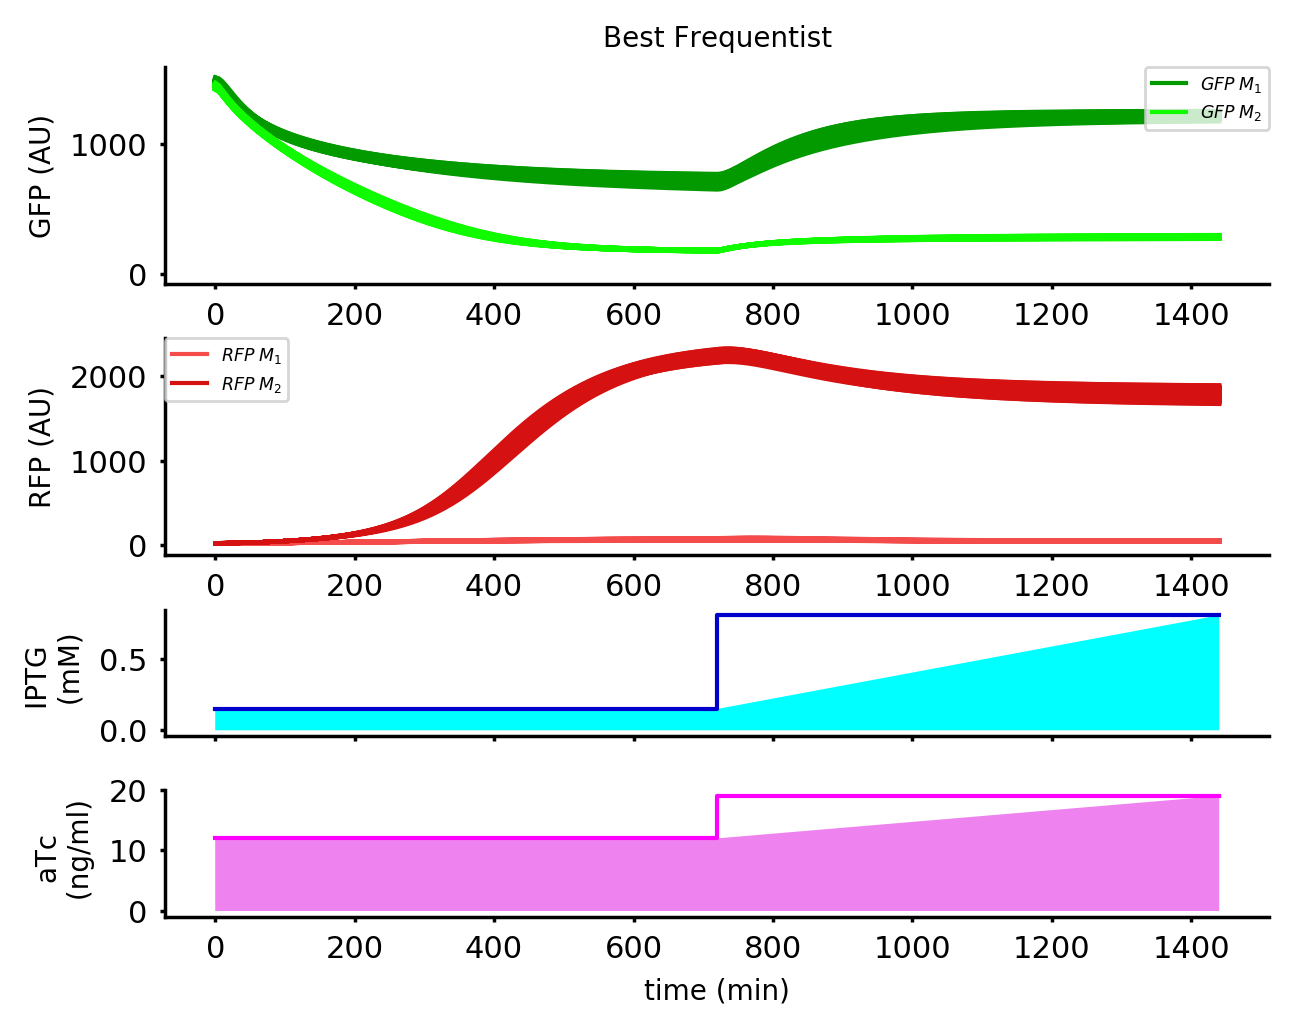

In [14]:

fig = plt.figure(figsize=(5.7, 4.5), dpi = 250)
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8,"axes.tickslabelssize":8,"text.usetex" : True,"text.latex.unicode" : True})  
gs = gridspec.GridSpec(10, 1, hspace = 1.5)

ax1 = plt.subplot(gs[0:3, 0:2])
lines1 = ax1.plot(t, GFP_M1b,color='#039a00')
ax1.plot(0,0,color='#039a00', label = '$GFP \; M_{1}$')
lines2 = ax1.plot(t, GFP_M2b, color='#10fb00')
ax1.plot(0,0,color='#10fb00', label = '$GFP \; M_{2}$')
ax1.tick_params(length=1.5)
ax1.set_ylabel('GFP (AU)')
ax1.set_xlabel('time (min)')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlabel('')
ax1.set_title('Best Frequentist')


ax2 = plt.subplot(gs[3:6, 0:2])
lines1 = ax2.plot(t, RFP_M1b,color='#f44b4b')
ax2.plot(0,0,color='#f44b4b', label = '$RFP \; M_{1}$')
lines2 = ax2.plot(t, RFP_M2b, color='#d61111')
ax2.plot(0,0,color='#d61111', label = '$RFP \; M_{2}$')
ax2.tick_params(length=1.5)
ax2.set_ylabel('RFP (AU)')
ax2.set_xlabel('time (min)')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel('')



ax3 = plt.subplot(gs[6:8, 0:2])
ax3.step(sp, [freInput2[0], freInput2[0],freInput2[2]], 'mediumblue')
ax3.fill_between(sp, np.zeros(len(sp)), 
                 [freInput2[0], freInput2[0],freInput2[2]],facecolor='cyan')
ax3.set_xticklabels('')
ax3.set_ylabel('IPTG \n (mM)')
ax3.tick_params(length=1.5)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)



ax4 = plt.subplot(gs[8:10, 0:2])
ax4.step(sp, [freInput2[1], freInput2[1],freInput2[3]], 'fuchsia')
ax4.fill_between(sp, np.zeros(len(sp)), 
                 [freInput2[1], freInput2[1],freInput2[3]],facecolor='violet')
ax4.set_xlabel('time (min)')
ax4.set_ylabel('aTc \n (ng/ml)')
ax4.tick_params(length=1.5)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

# ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.legend(loc=1, borderaxespad=0., prop={'size': 5})
ax2.legend(loc=2, borderaxespad=0., prop={'size': 5})
plt.show()
fig.savefig('FrequentistOptimisationBestMultiplicative2Steps.png')

In [16]:
FGM1 = np.std(GFP_M1b,1)
FGM2 = np.std(GFP_M2b,1)
FRM1 = np.std(RFP_M1b,1)
FRM2 = np.std(RFP_M2b,1)

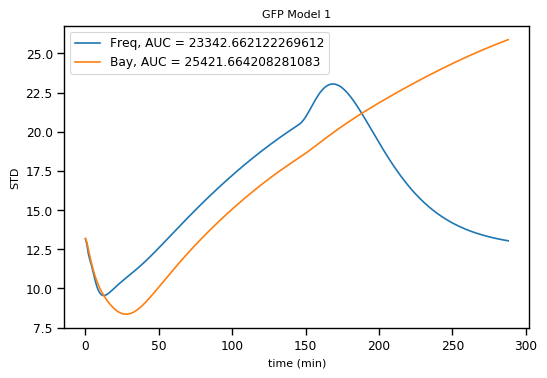

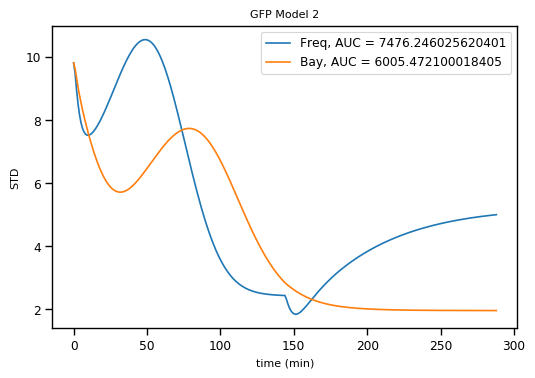

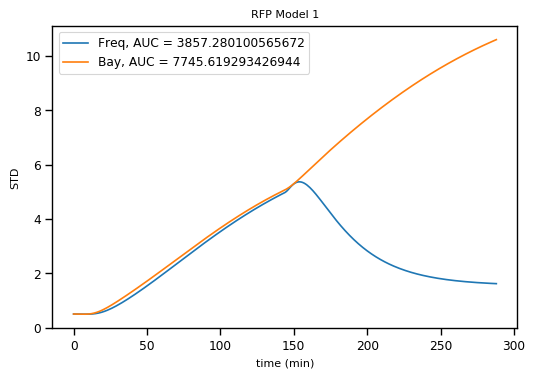

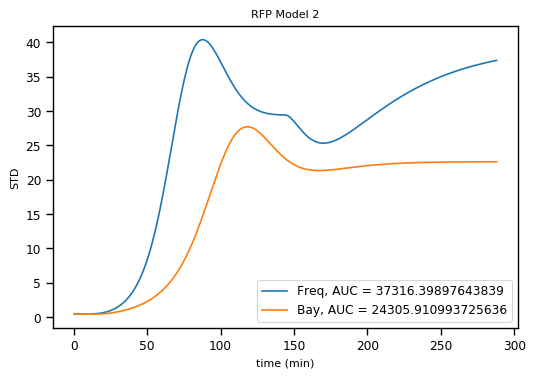

In [20]:

plt.figure(dpi=100)
a1 = sklearn.metrics.auc(t, FGM1)
a2 = sklearn.metrics.auc(t, BGM1)
plt.plot(FGM1, label='Freq, AUC = '+str(a1))
plt.plot(BGM1, label='Bay, AUC = '+str(a2))
plt.legend()
plt.title('GFP Model 1')
plt.ylabel('STD')
plt.xlabel('time (min)')
plt.show()

plt.figure(dpi=100)
a1 = sklearn.metrics.auc(t, FGM2)
a2 = sklearn.metrics.auc(t, BGM2)
plt.plot(FGM2, label='Freq, AUC = '+str(a1))
plt.plot(BGM2, label='Bay, AUC = '+str(a2))
plt.legend()
plt.title('GFP Model 2')
plt.ylabel('STD')
plt.xlabel('time (min)')
plt.show()

plt.figure(dpi=100)
a1 = sklearn.metrics.auc(t, FRM1)
a2 = sklearn.metrics.auc(t, BRM1)
plt.plot(FRM1, label='Freq, AUC = '+str(a1))
plt.plot(BRM1, label='Bay, AUC = '+str(a2))
plt.legend()
plt.title('RFP Model 1')
plt.ylabel('STD')
plt.xlabel('time (min)')
plt.show()

plt.figure(dpi=100)
a1 = sklearn.metrics.auc(t, FRM2)
a2 = sklearn.metrics.auc(t, BRM2)
plt.plot(FRM2, label='Freq, AUC = '+str(a1))
plt.plot(BRM2, label='Bay, AUC = '+str(a2))
plt.legend()
plt.title('RFP Model 2')
plt.ylabel('STD')
plt.xlabel('time (min)')
plt.show()

In [21]:
a1 = sklearn.metrics.auc(t, FGM1)
a2 = sklearn.metrics.auc(t, BGM1)

a3 = sklearn.metrics.auc(t, FGM2)
a4 = sklearn.metrics.auc(t, BGM2)

a5 = sklearn.metrics.auc(t, FRM1)
a6 = sklearn.metrics.auc(t, BRM1)

a7 = sklearn.metrics.auc(t, FRM2)
a8 = sklearn.metrics.auc(t, BRM2)

print('Total AUC for Bayesian case: '+str(a2+a4+a6+a8))
print('Total AUC for Frequentist case: '+str(a1+a3+a5+a7))

Total AUC for Bayesian case: 63478.666595452065
Total AUC for Frequentist case: 71992.58722489407
